In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
import scipy.stats as stats
from statsmodels.stats import weightstats as stests
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [3]:
# Versions:

print("Pandas version :" , pd.__version__)
print("Numpy version: ", np.__version__)
from sklearn import __version__
print("scikitlearn version :",__version__)
from platform import python_version
print("Python version: ",python_version())

Pandas version : 2.2.2
Numpy version:  1.26.4
scikitlearn version : 1.5.2
Python version:  3.10.12


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!ls drive/MyDrive/Datasets

bank_data.csv  cars-mpg.csv  german_credit.csv		 SuperKart.csv
bank_full.csv  chart.png     pima-indians-diabetes.data  Telco-Customer-Churn.csv
car-mpg.csv    EasyVisa.csv  Social_Network_ads.csv	 usedcars.csv


In [6]:
data=pd.read_csv('drive/MyDrive/Datasets/cars-mpg.csv') # Loading csv data into a python data frame

In [7]:
data.shape # the output suggests that the data set has 398 rows and 8 columns which can also be referred to as depth and breadth analysis.
           # Data sets with large breadth(too many columns) and small depth(too few rows) will lead to curse of dimensionality
           # situation where models will tend to become overfit.
           # to avoid model overfitting we will have to regularize the models,such as using ridge or lasso.

(398, 8)

In [8]:
data.head(5)

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


In [9]:
# Car name being a object data type(srings) should be removed from the analysis.
data=data.drop('car name',axis=1)

# Descriptive Statistics

In [10]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


## Observations


1. Since all columns have same number of records, it is indicated that there are no missing values in any of the columns.
2. The absence of Horsepower column suggests that the column has some data quality issues.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cyl     398 non-null    int64  
 1   disp    398 non-null    float64
 2   hp      398 non-null    object 
 3   wt      398 non-null    int64  
 4   acc     398 non-null    float64
 5   yr      398 non-null    int64  
 6   mpg     398 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 21.9+ KB


In [12]:
data.memory_usage(deep=True)  # memory usage in bytes

,0
Index,128
cyl,3184
disp,3184
hp,23643
wt,3184
acc,3184
yr,3184
mpg,3184


In [10]:
data_copy = data.copy()
data_copy['cyl'] = pd.to_numeric(data_copy['cyl'], downcast='unsigned')
data_copy['wt'] = pd.to_numeric(data_copy['wt'], downcast='unsigned')
data_copy['yr'] = pd.to_numeric(data_copy['yr'], downcast='unsigned')

data_copy['disp'] = pd.to_numeric(data_copy['disp'], downcast='float')
data_copy['acc'] = pd.to_numeric(data_copy['acc'], downcast='float')
data_copy['mpg'] = pd.to_numeric(data_copy['mpg'], downcast='float')

In [14]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cyl     398 non-null    uint8  
 1   disp    398 non-null    float32
 2   hp      398 non-null    object 
 3   wt      398 non-null    uint16 
 4   acc     398 non-null    float32
 5   yr      398 non-null    uint8  
 6   mpg     398 non-null    float32
dtypes: float32(3), object(1), uint16(1), uint8(2)
memory usage: 9.5+ KB


In [15]:
data_copy.memory_usage(deep=True)  # memory usage in bytes

,0
Index,128
cyl,398
disp,1592
hp,23643
wt,796
acc,1592
yr,398
mpg,1592


1. Horsepower (hp) data type is object not numeric. This shows non numerical charecters are present in this column.
2. Identify the records with the data problem in this column.

In [11]:
temp_hp=pd.DataFrame(data.hp.str.isdigit()) # The 'isdigit' is a boolean function. Returns true if columns of a row contain
                                            # numeric value. Returns 'False' if it finds non-numeric values
                                            # temp_hp array will cotain 398 "True" or "False" enteries.
                                            # Those rows where any column has non-numeric, will have "False" in the array

temp_hp[temp_hp['hp'] == False] # Selecting all rows from the array which have "False"

,hp
32,False
126,False
330,False
336,False
354,False
374,False


Visual inspection shows that these 6 records have '?' in the hp column.
Maybe the data entry operator left '?' where data was missing.

# Missing Value identification and treatment

Missing Value treatment steps

1. Replace '?' with NaN. This helps in using fillna function to replace the missing values.
2. Replace all the NaN values with the median of the horsepower column. (median is least affected by the preasence of outliers)


In [12]:
data=data.replace('?',np.nan)

In [13]:
#checking if the above code worked.
data[data.isnull().any(axis=1)]  #NaN is equal to null, hence we can use the isnull function to check whether the records with '?'
                                 # have been correctly imputed with NaN.

,cyl,disp,hp,wt,acc,yr,mpg
32,4,98.0,NaN,2046,19.0,71,25.0
126,6,200.0,NaN,2875,17.0,74,21.0
330,4,85.0,NaN,1835,17.3,80,40.9
336,4,140.0,NaN,2905,14.3,80,23.6
354,4,100.0,NaN,2320,15.8,81,34.5
374,4,151.0,NaN,3035,20.5,82,23.0


In [19]:
data.describe()

,cyl,disp,wt,acc,yr,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,2970.424623,15.568090,76.010050,23.514573
std,1.701004,104.269838,846.841774,2.757689,3.697627,7.815984
min,3.000000,68.000000,1613.000000,8.000000,70.000000,9.000000
25%,4.000000,104.250000,2223.750000,13.825000,73.000000,17.500000
50%,4.000000,148.500000,2803.500000,15.500000,76.000000,23.000000
75%,8.000000,262.000000,3608.000000,17.175000,79.000000,29.000000
max,8.000000,455.000000,5140.000000,24.800000,82.000000,46.600000


In [14]:
data['hp']=data['hp'].astype('float16') #change the data type ofhorsepower to numeric data type.

## Strategy 1 - Replace missing values with nearest neighbor based approach

In [15]:
from sklearn.impute import KNNImputer

In [16]:
imputer = KNNImputer(n_neighbors=5, weights="distance")
data_imputed_knn =  pd.DataFrame(imputer.fit_transform(data), columns = data.columns )

In [17]:
# [32,126,330,336,354,374]

data_imputed_knn.iloc[[32,126,330,336,354,374]]

,cyl,disp,hp,wt,acc,yr,mpg
32,4.0,98.0,63.140357,2046.0,19.0,71.0,25.0
126,6.0,200.0,105.859982,2875.0,17.0,74.0,21.0
330,4.0,85.0,63.961307,1835.0,17.3,80.0,40.9
336,4.0,140.0,109.182895,2905.0,14.3,80.0,23.6
354,4.0,100.0,74.394250,2320.0,15.8,81.0,34.5
374,4.0,151.0,88.448743,3035.0,20.5,82.0,23.0


## Strategy 2 - replace missing values with central values such as median

In [18]:
data.median()  #check the median of all the columns.

,0
cyl,4.0
disp,148.5
hp,93.5
wt,2803.5
acc,15.5
yr,76.0
mpg,23.0


In [19]:
data_imputed_median=data.apply(lambda x:x.fillna(x.median()),axis=0)  # Lambda function takes as input a column name and replaces all the
                                                       # NaN in the column with the columns median.

In [20]:
data_imputed_median.iloc[[32,126,330,336,354,374]]

,cyl,disp,hp,wt,acc,yr,mpg
32,4,98.0,93.5,2046,19.0,71,25.0
126,6,200.0,93.5,2875,17.0,74,21.0
330,4,85.0,93.5,1835,17.3,80,40.9
336,4,140.0,93.5,2905,14.3,80,23.6
354,4,100.0,93.5,2320,15.8,81,34.5
374,4,151.0,93.5,3035,20.5,82,23.0


In [21]:
# We will go with the KNN imputation approach and use that data for further processing

data=data_imputed_knn.copy()

## Descriptive Analytics

In [22]:
data.describe().transpose() # transpose is only to get the column names on the vertical axis.

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
hp,398.0,104.163285,38.347170,46.0,75.000,92.5,125.000,230.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


## Key Observations

For disp column
1. Disp column mean (193.42) is greater than median (148.5) indicating preasence of long tail on the right side of the distribution.
2. The left side tail( difference between 1st quartile and minima) is 36 units approx. while the right side tail ( max - 3rd quartile) is 193 units,more than 5 times longer than the left side tail. This indicated preasence of potential outliers on the right side.
3. The difference between 3rd quartile (262) and 2nd quartile (148.5) is 113.5 units. The difference between 2nd quartile and first quartile (104.25) is 44.25 units, this indicates that there is a skew in the distribution.

Similar analysis can be done for all other numerical columns to understand the distribution charecteristics and identify columns with potential outliers.
We can do the same analysis using the skew function or visual approach of the sns pairplot.

In [ ]:
# computing the skewness in each column.
Skewness = pd.DataFrame({'Skewness' : [stats.skew(data.cyl),stats.skew(data.disp),stats.skew(data.hp),
                                      stats.skew(data.wt),stats.skew(data.acc),stats.skew(data.yr)]},
                        index=['cyl','disp','hp','wt','acc','yr'])
Skewness

,Skewness
cyl,0.524934
disp,0.716930
hp,1.095284
wt,0.529059
acc,0.277725
yr,0.011491


## Observations

1. From the above table for skewness we can infer that hp is highly skewed and disp is moderately skewed.
2. Skew range and interpretation

    a. if skewness is less than -1 or more than 1, the distribution is highly skewed
    b. if skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed
    c. if skewness is between -0.5 and 0.5 the distribution is approximately symmetric.



## Visualise the distributions using displot.

<ipython-input-209-6258bb75198b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['cyl'], color='lightgreen')
<ipython-input-209-6258bb75198b>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['disp'], color='lightgreen')
<ipython-input-209-6258bb75198b>:9: UserWarning: 

`distplot` is 

<Axes: xlabel='yr', ylabel='Density'>

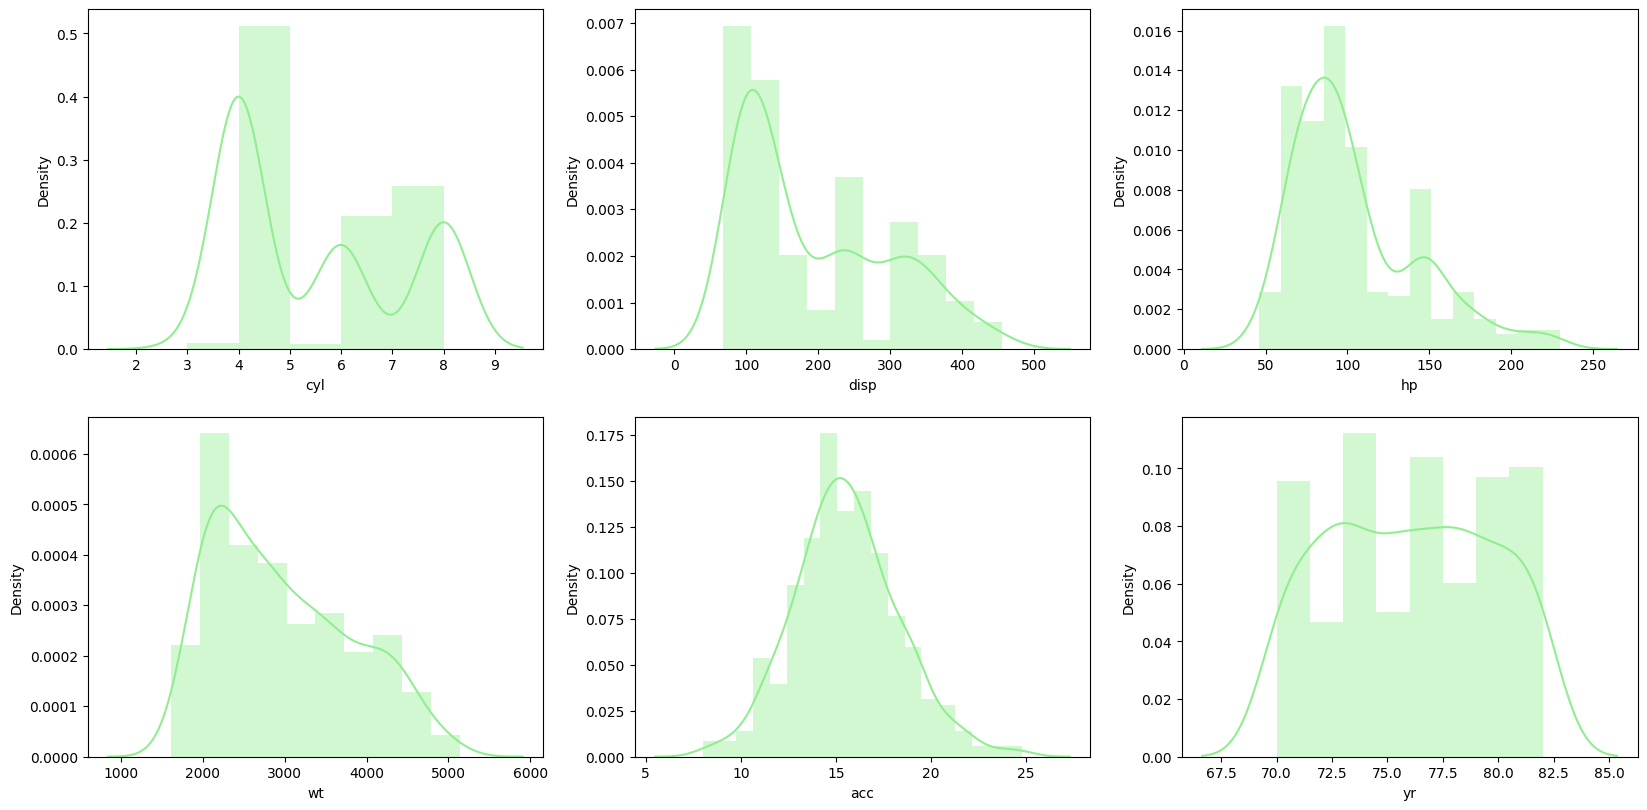

In [ ]:
plt.figure(figsize= (20,15))
plt.subplot(3,3,1)
sns.distplot(data['cyl'], color='lightgreen')

plt.subplot(3,3,2)
sns.distplot(data['disp'], color='lightgreen')

plt.subplot(3,3,3)
sns.distplot(data['hp'], color='lightgreen')

plt.subplot(3,3,4)
sns.distplot(data['wt'], color='lightgreen')

plt.subplot(3,3,5)
sns.distplot(data['acc'], color='lightgreen')

plt.subplot(3,3,6)
sns.distplot(data['yr'], color='lightgreen')

## Observations

1. We can see multiple peaks in the plot for cyl, this is because the column values are discrete.(4,6 and 8)
2. Variables disp,hp anf wt are right skewed indicating possible outliers
3. Acc show a symmetric distribution which shows ver few cars with large and small values most have acceleration centered at 15 - 17 units. Most of the cars seem to be small and mid size.

Given the long tails in some distributions, let us analyze the distributions using box plot as that will highlight the outliers.

<Axes: xlabel='acc'>

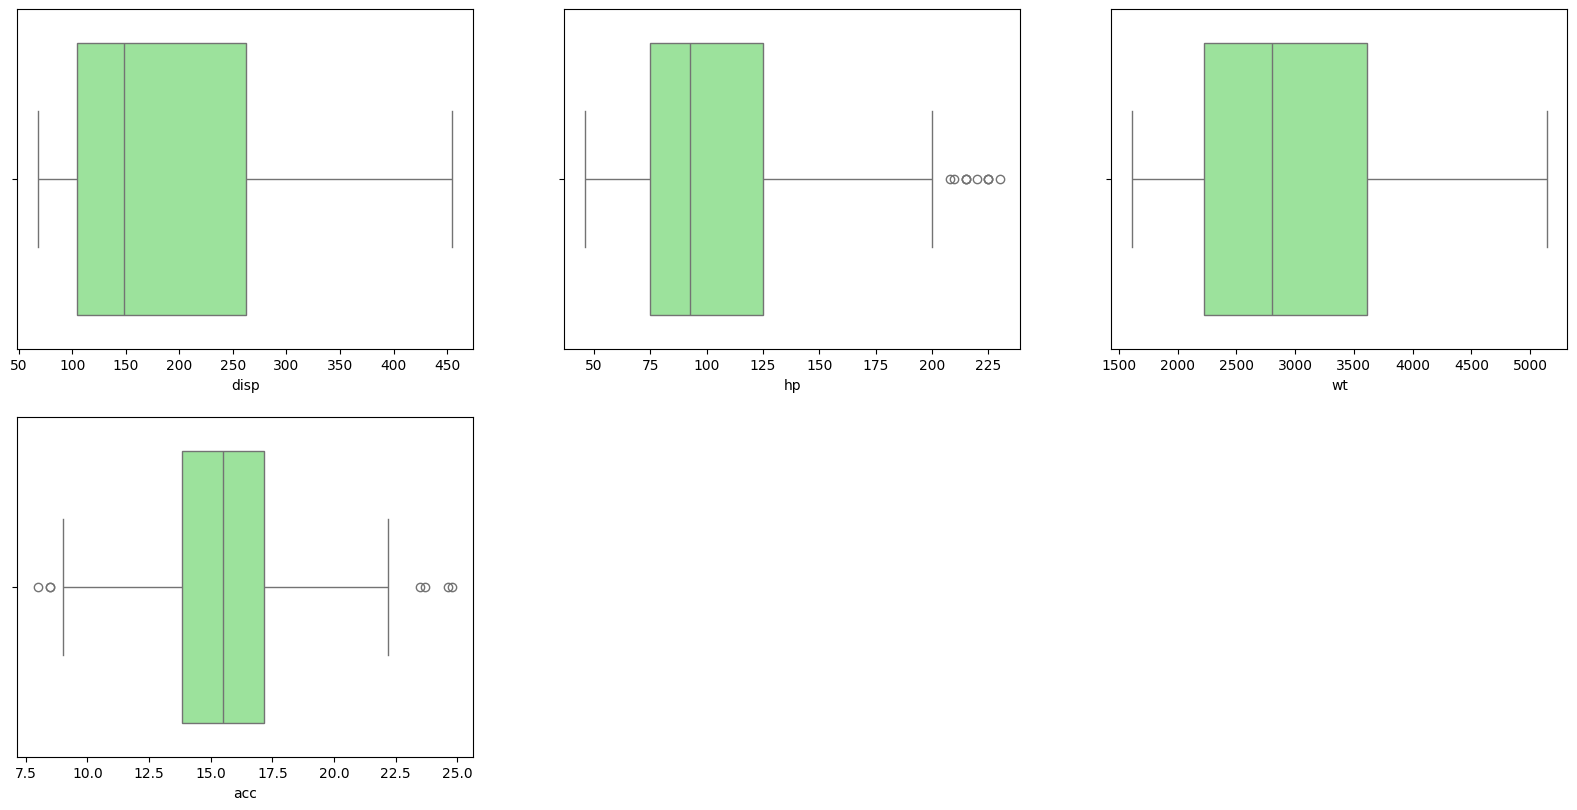

In [ ]:
#using boxplots to visualise the outliers
plt.figure(figsize= (20,15))

plt.subplot(3,3,1)
sns.boxplot(x= data.disp, color='lightgreen')

plt.subplot(3,3,2)
sns.boxplot(x= data.hp, color='lightgreen')

plt.subplot(3,3,3)
sns.boxplot(x= data.wt, color='lightgreen')

plt.subplot(3,3,4)
sns.boxplot(x= data.acc, color='lightgreen')


## Observations

1. Boxplot is done only for continuous variables
2. Outliers (1.5 std deviations + or - 3rd quartile, 1st quartile respectively) are present only in hp and acc. Some use 1.5*IQR to define outliers. Any point beyone LL  = Q1 - 1.5IQR , UL = Q3 + 1.5 IQR is an outlier
3. Hp column seems to have cars with extreme high values for horsepower.
4. Acceleration column seems to have extreme values both on lower side and upper side.
5. The outliers could be because of typing errors or rare but possible casses.
6. Displacement column seems to have relatively large right skew in the body of the distribution though it does not have any outliers.

Given the outliers we need to explore the reasons for these outliers and fix them if required.

In [23]:
temp_out_hp= (data['hp']>190)
outliers = temp_out_hp[temp_out_hp==True]
print(outliers)

5      True
6      True
7      True
8      True
13     True
25     True
26     True
27     True
28     True
67     True
90     True
94     True
95     True
116    True
Name: hp, dtype: bool


In [24]:
data.iloc[outliers.index]

,cyl,disp,hp,wt,acc,yr,mpg
5,8.0,429.0,198.0,4341.0,10.0,70.0,15.0
6,8.0,454.0,220.0,4354.0,9.0,70.0,14.0
7,8.0,440.0,215.0,4312.0,8.5,70.0,14.0
8,8.0,455.0,225.0,4425.0,10.0,70.0,14.0
13,8.0,455.0,225.0,3086.0,10.0,70.0,14.0
25,8.0,360.0,215.0,4615.0,14.0,70.0,10.0
26,8.0,307.0,200.0,4376.0,15.0,70.0,10.0
27,8.0,318.0,210.0,4382.0,13.5,70.0,11.0
28,8.0,304.0,193.0,4732.0,18.5,70.0,9.0
67,8.0,429.0,208.0,4633.0,11.0,72.0,11.0


## Observations on hp outliers

1. All the cars have valid hp values as per the information on the web
2. Some of these cars are rare as they were manufactured only in few numbers.

In [25]:
# identifying outlier records in acc

temp_out_acc= (data['acc']<10) | (data['acc']>21)
outliers = temp_out_acc[temp_out_acc==True]
print(outliers)

6      True
7      True
9      True
11     True
12     True
59     True
116    True
195    True
196    True
209    True
244    True
299    True
300    True
325    True
326    True
328    True
394    True
Name: acc, dtype: bool


In [26]:
data.iloc[outliers.index]

,cyl,disp,hp,wt,acc,yr,mpg
6,8.0,454.0,220.0,4354.0,9.0,70.0,14.0
7,8.0,440.0,215.0,4312.0,8.5,70.0,14.0
9,8.0,390.0,190.0,3850.0,8.5,70.0,15.0
11,8.0,340.0,160.0,3609.0,8.0,70.0,14.0
12,8.0,400.0,150.0,3761.0,9.5,70.0,15.0
59,4.0,97.0,54.0,2254.0,23.5,72.0,23.0
116,8.0,400.0,230.0,4278.0,9.5,73.0,16.0
195,4.0,85.0,52.0,2035.0,22.2,76.0,29.0
196,4.0,98.0,60.0,2164.0,22.1,76.0,24.5
209,4.0,120.0,88.0,3270.0,21.9,76.0,19.0


## Observations for outliers in acceleration column

1. Acceleration column reflects the amount of time in seconds taken by a car to reach 60mph ( approx. 100kmh).
2. Some cars listed above have significantly lower acceleration (take more time to reach 60mph) than specified in their specs.
3. This could be due to the age factor (old cars have lower acceleration than specified) or a typo.
4. The strategies for replacing outliers could be as follows
         a. Since there are cars whith similar age and brand but very low acceleration we can replace the outliers brandwise. However this can become a difficult option as the car names are not standardised.
         b. Replace outliers with values imputed using knn algorithm as this will ensure all similar cars have similar acceleration. However this may not be true in the real world. Two cars similar in size, weight, year of manufacture etc. may have different acceleration.
         c. Replace outliers with median of the column because median as a central value represents the charecteristic of all the cars. However this can be misleading as the charecteristicsof the car can be very different. for eg as small car will have larger acceleration value than a big heavy SUV.
         d. Group the cars based on charecteristics and replace the outliers groupwise. This approach is similar to knn and hence has the same drawback as knn.
         e. Replace the outliers with the quartile values ( also known as capping). Since most of the outliers are close to the edge of 1.5 std dev from the quartiles this method seems to be the safest approach compared to others in terms of the impact on the distribution charecteristics of the column.
         
5. In this case we are going to use the approach in 4.e. to replace outliers
6. Whichever approach we use should be verified by doing a hypothesis testing on the column before and after the outlier fixing. For eg. using paired t-test.
         

In [27]:
data_copy = data.copy()

## Handling outliers

1. Even though the outliers in horsepower column are valid values we will replace them with the nearest quartiles as there are only few records (14) with these extreme values.
2. We are replacing the outliers in acceleration column with the quartile values.
     

In [28]:
 # Function to replace outliers with whisker values
def replace_outliers_with_whiskers(df, col):
  # Calculate Q1 (25th percentile) and Q3 (75th percentile)
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)

  # Calculate Interquartile Range (IQR)
  IQR = Q3 - Q1
  # Define the lower and upper whisker
  lower_whisker = Q1 - 1.5 * IQR
  upper_whisker = Q3 + 1.5 * IQR

  # Replace outliers lower than the lower whisker with the lower whisker

  df[col] = df[col].apply(lambda x: lower_whisker if x < lower_whisker else x)

  # Replace outliers greater than the upper whisker with the upper whisker
  df[col] = df[col].apply(lambda x: upper_whisker if x > upper_whisker else x)

  return df




In [29]:
# Replace outliers in 'column_name'
data = replace_outliers_with_whiskers(data, 'hp')

data = replace_outliers_with_whiskers(data, 'acc')


In [30]:
 '''Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)


data['hp']=data['hp'].clip(lower=data['hp'].quantile(0.05), upper=data['hp'].quantile(0.95))
data['acc']=data['acc'].clip(lower=data['acc'].quantile(0.05), upper=data['acc'].quantile(0.95))
'''

"Q1 = df[column].quantile(0.25)\n   Q3 = df[column].quantile(0.75)\n\n\ndata['hp']=data['hp'].clip(lower=data['hp'].quantile(0.05), upper=data['hp'].quantile(0.95))\ndata['acc']=data['acc'].clip(lower=data['acc'].quantile(0.05), upper=data['acc'].quantile(0.95))\n"

Now that the outliers have been replaced, lets plot the boxplots again to check if we've managed to get rid of the outliers

<Axes: ylabel='hp'>

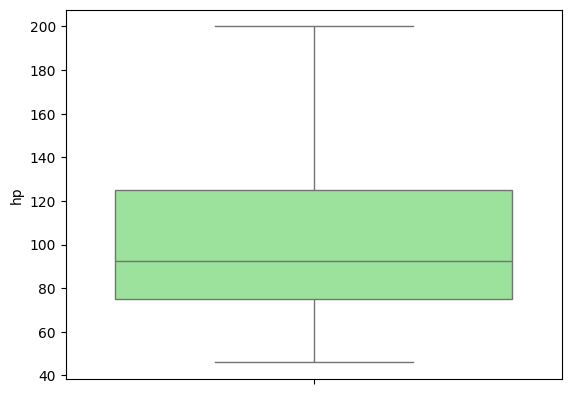

In [31]:
sns.boxplot(data['hp'],color='lightgreen')


<Axes: ylabel='acc'>

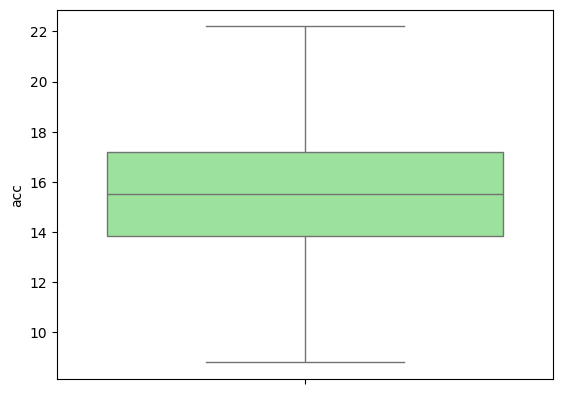

In [32]:
sns.boxplot(data['acc'],color='lightgreen')

Note : Though in this case the outliers have been addressed for both the columns and we do not see any new outliers, this may not be the case all the time. The reason is by fixing outliers we modify the standard deveations (reduce) and as a result we reduce the vlaue of 1.5 standard deveation. Because of this reduced 1.5 standard deveation data points which were earlier not outliers may now appear as outliers.
In case we observe new outliers we can ignore them and continue with our processing.

##  Hypothesis Testing for impact of outlier fixing using dependent t test

In [33]:
# Ho : No significant difference in the distribution after outlier treatment
# Ha : There is a significant difference in the distribution after outlier treatment

# for hp column
t, pval= stats.ttest_ind(data_copy['hp'],data['hp'])
print(float(pval))
if pval<0.05:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')


0.8596844138571165
accept null hypothesis


Based on hypothesis testing of the horsepower column the stratergy of replacing outliers in horsepower with quartiles is OK as we fail to reject null hypothesis.

In [34]:
# Ho : No significant difference in the distribution after outlier treatment
# Ha : There is a significant difference in the distribution after outlier treatment

# for acc column
t, pval= stats.ttest_ind(data_copy['acc'],data['acc'])
print(float(pval))
if pval<0.05:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')


0.9336919910906359
accept null hypothesis


Based on hypothesis testing of the acc column the stratergy of replacing outliers in acc with quartiles is OK as we fail to reject null hypothesis.

In [35]:
# for acc column
t, pval= stats.ttest_rel(data_copy['acc'],data['acc'])
print(float(pval))
if pval<0.05:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')

0.1238059428910082
accept null hypothesis


Since the outliers in the hp column were actual ground truth values, let us not fix those outliers


In [36]:
data['hp']=data_copy['hp'] # copyting data from the backup for horsepower column to eliminate the imputed values for outliers.

## Feature Selection and correlation analysis

We can do a correlation analysis between the attributes to understand the strength and direction of correlation between the dependent (mpg) , independent (other variables) and between the independent variables.

(7.5, -0.5)

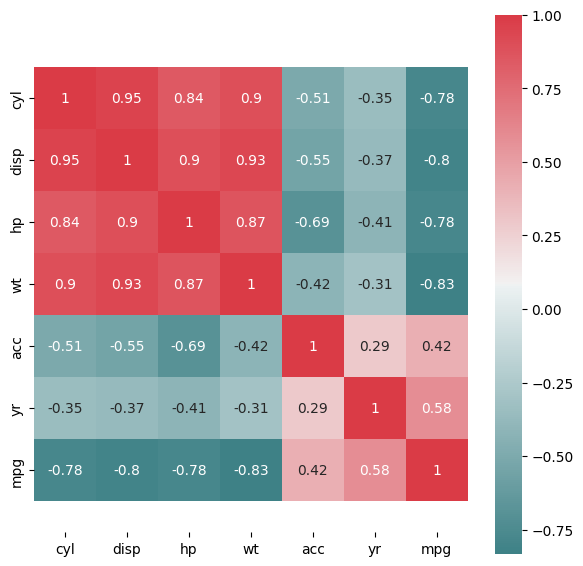

In [37]:
f, ax = plt.subplots(figsize=(7, 7))
corr=data.corr('pearson')
cp=sns.heatmap(corr,mask=np.zeros_like(corr,dtype=bool),cmap=sns.diverging_palette(200,10,as_cmap=True),square=True,ax=ax,annot=True)
bottom,top = cp.get_ylim()
cp.set_ylim(bottom+0.5,top-0.5) #matplotlib version to 3.1.1 has a bug in the plot and mistakes in the y-axis

## Observations

1. mpg has a strong negative correlation with cyl (-0.78), displacement (-0.8), hp (-0.77) and wt (-0.83). This is as per our understanding of the relation between these variables and mpg.
2. Between mpg and acc, yr we see a positive weak correlation.
3. As the yr ( year of manufacture) increases the car becomes younger in age and hence mileage is higher, this causes the positive correlation between mpg and year.
4. The correlation between mpg and acc is small and positive, the reason for this is small cars accelerate faster and also give higher mileage. However the weak correlation (0.41) is surprising as we expect to see a strong positive correlation.
5. The correlation between the cylinder and mpg columns is strong negative, thisis due to the fact that as number of cylinders increase the loss due to friction and heat increase leading to lower mileage.
6. Between the attributes, such as horse power, weight, displacement and cylinder we see a strong positive colinearity (correlation between independent attributes). This shows that the attributes are not truly independent of each other.
7. We can use the columns cylinder, displacement, horesepower, weight and year to predict miles per gallon.
8. Corr plot gives a quantitative idea about the correlation but we also need to check whether the correlation is strictly linear or curved for which we will use pairplot.

## Pairplot Analysis

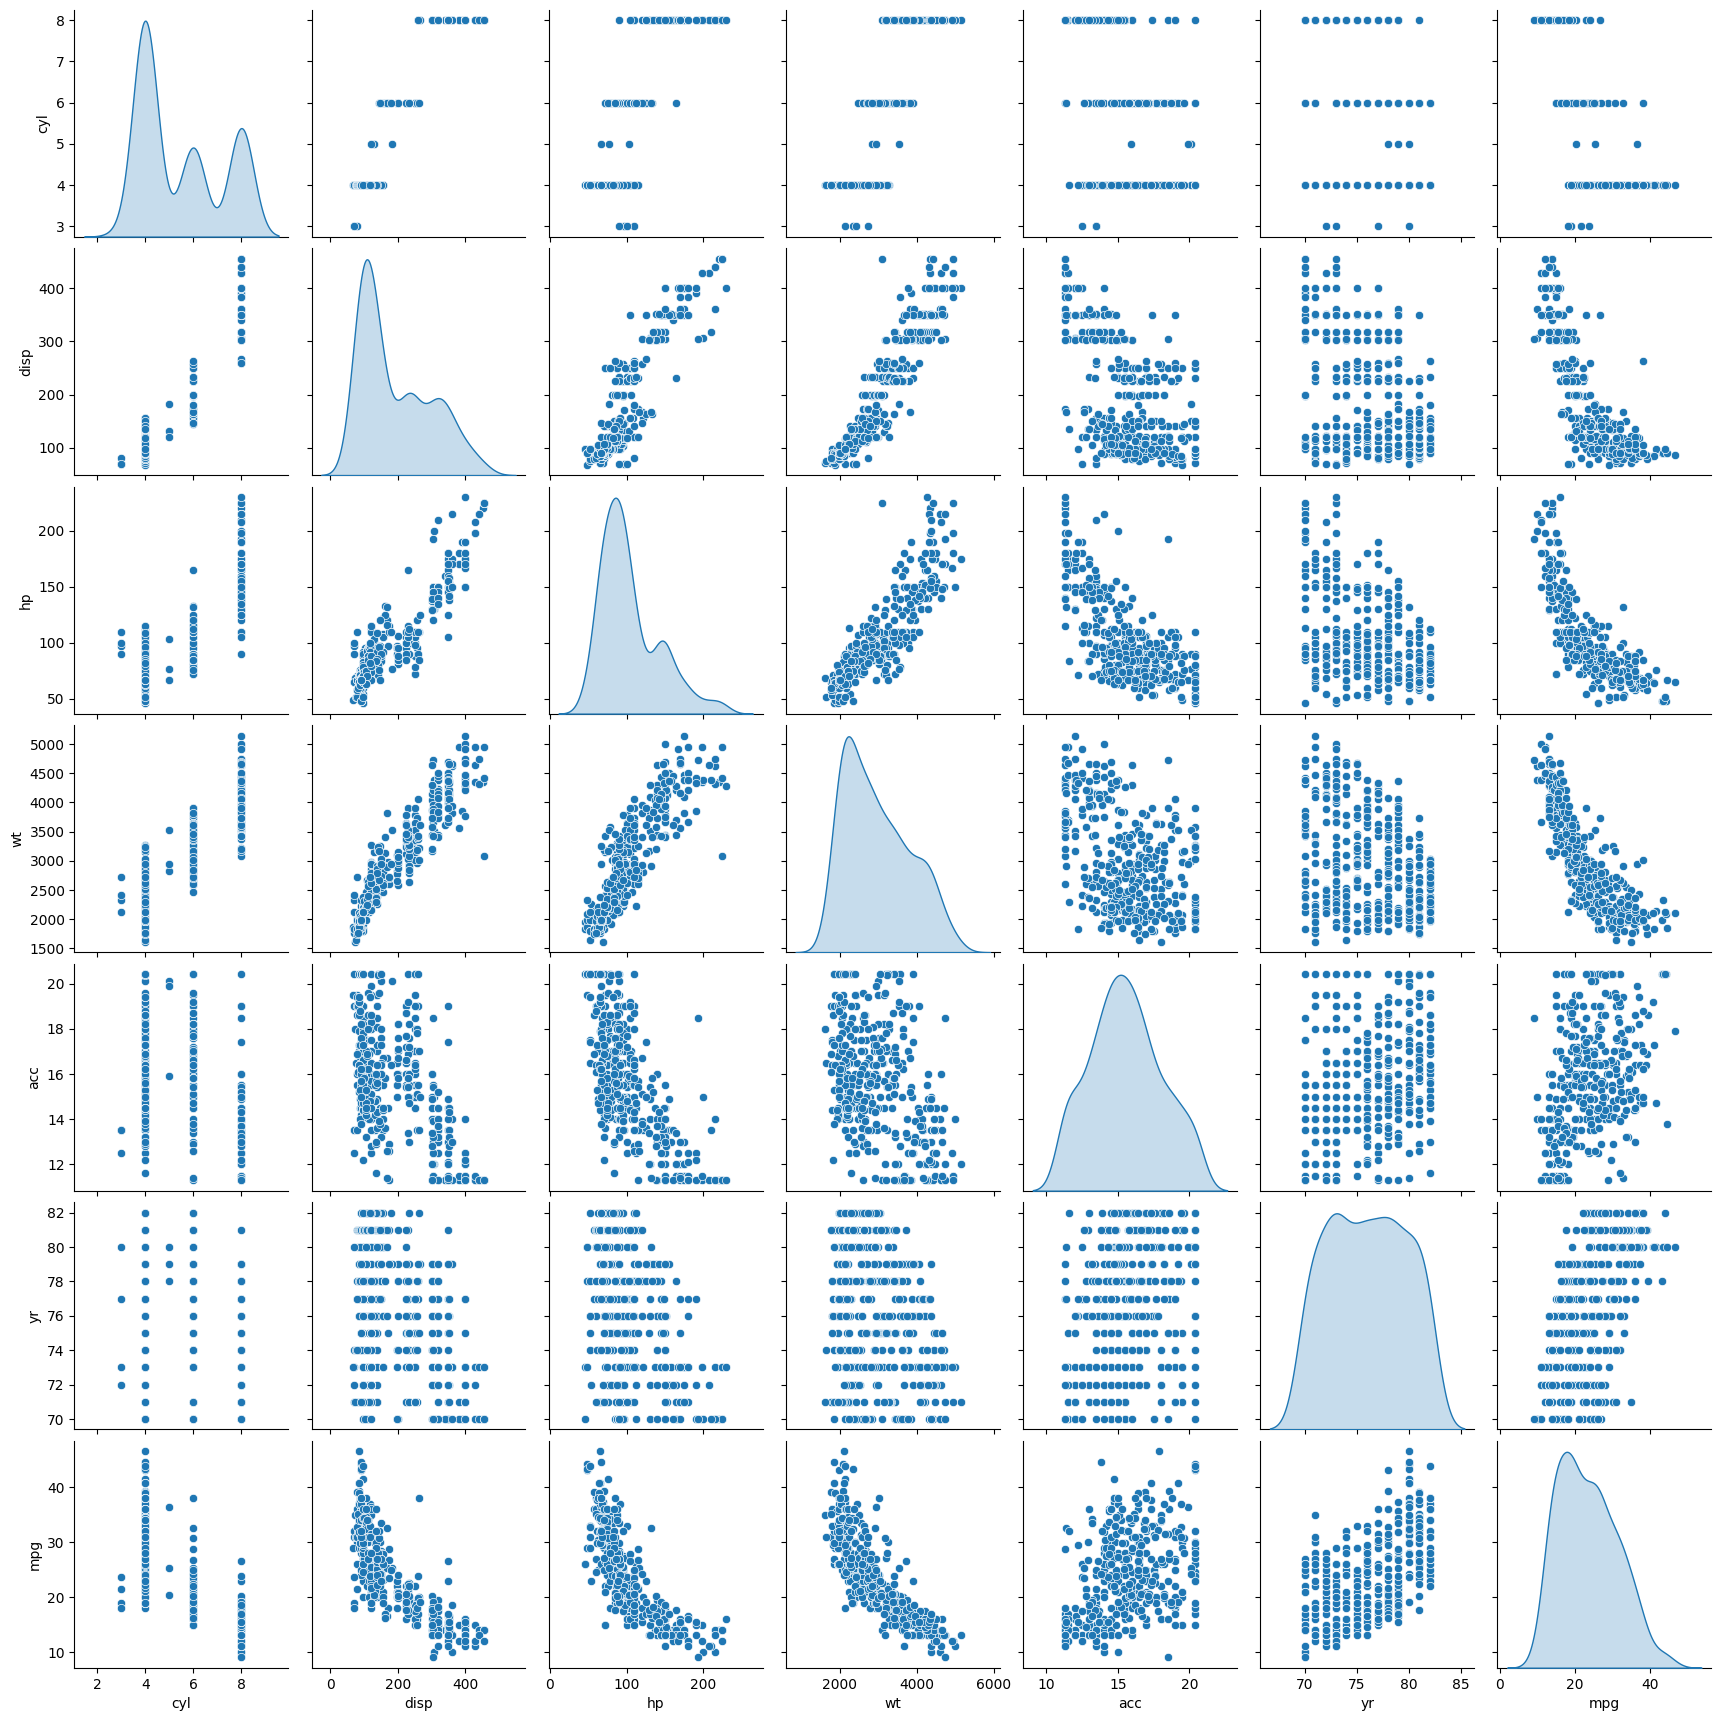

In [ ]:
sns.pairplot(data,diag_kind='kde') # kde stands for kernel density estimate, i.e. how the distribution is in the population,
                                   # based on gaussian projection of the data at hand
                                   # using a mathematical function also called kernel.

## Observations

1. Diagonal analysis
    a. In the cylinder column we see three peaks because this is a categorical column where majority of the car have 3 distinct values.
    b. In disp column again we see multiple peaks which should be explored to understand what causes these peaks, is it because of missing values or some kind of natureal groupings in the data.

2. Off - daigonal
    a. The relationship between mpg and disp, hp and weight is not strictly linear. We can see a curvature in the scatterplot.
    b. In the scatterplot for mpg vs acc we see a weak positive correlation but the scatter plot looks almost like a cloud indicating that it is not likely to be a good predictor of mpg.
    c. Between mpg and year we see a weak linear positive correlation.
    d. Between the attributes cyl,disp,hp,wt and yr we see strong positive colinearity.

Lets explore the occurences of multiple peaks in the various columns and check the preasence of any clusters in the data.

## Clustering

In [38]:
from scipy.stats import zscore
data_z=data_copy.apply(zscore)

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

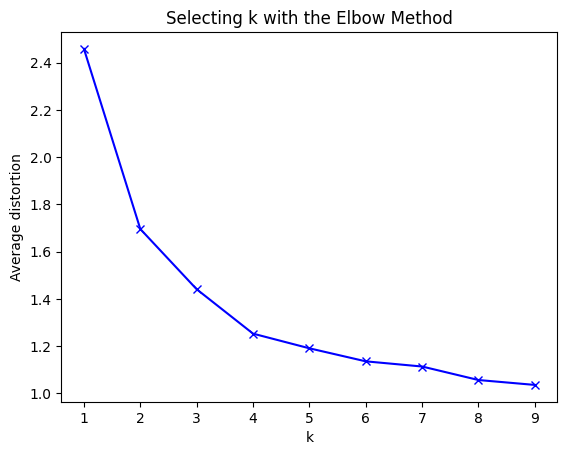

In [39]:
# Finding the optimal number of clusters using Elbow method


clusters=range(1,10)  # creating one single cluster is useless, starting from two
meanDistortions=[] # array to hold within cluster variance, a.k.a inertia

for k in clusters:
    model= KMeans(n_clusters=k)
    model.fit(data_z)
    prediction= model.predict(data_z)
    meanDistortions.append(sum(np.min(cdist(data_z, model.cluster_centers_, 'euclidean'), axis=1)) / data_z.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')  # usign blue cross for every number of cluster value and mean distortion
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

# Note: we can replace calculation of meandistortion with another function called cluster.inertia that does all the calculation
# automatically
#meanDistortion.append(model.inertia_)

In [47]:
# Let us first start with K = 4
final_model=KMeans(4)
final_model.fit(data_z)   # defines three clusters
prediction=final_model.predict(data_z)  # captures which cluster each data point in the datset belongs to

#Append the prediction
data_z["Group"] = prediction  # creating a new column in the dataframe to reflect which cluster a record belongs to

In [48]:
data_z.groupby(['Group']).count()

,cyl,disp,hp,wt,acc,yr,mpg
Group,,,,,,,
0,78,78,78,78,78,78,78
1,87,87,87,87,87,87,87
2,95,95,95,95,95,95,95
3,138,138,138,138,138,138,138


array([[<Axes: title={'center': 'acc'}, xlabel='[Group]'>,
        <Axes: title={'center': 'cyl'}, xlabel='[Group]'>,
        <Axes: title={'center': 'disp'}, xlabel='[Group]'>],
       [<Axes: title={'center': 'hp'}, xlabel='[Group]'>,
        <Axes: title={'center': 'mpg'}, xlabel='[Group]'>,
        <Axes: title={'center': 'wt'}, xlabel='[Group]'>],
       [<Axes: title={'center': 'yr'}, xlabel='[Group]'>, <Axes: >,
        <Axes: >]], dtype=object)

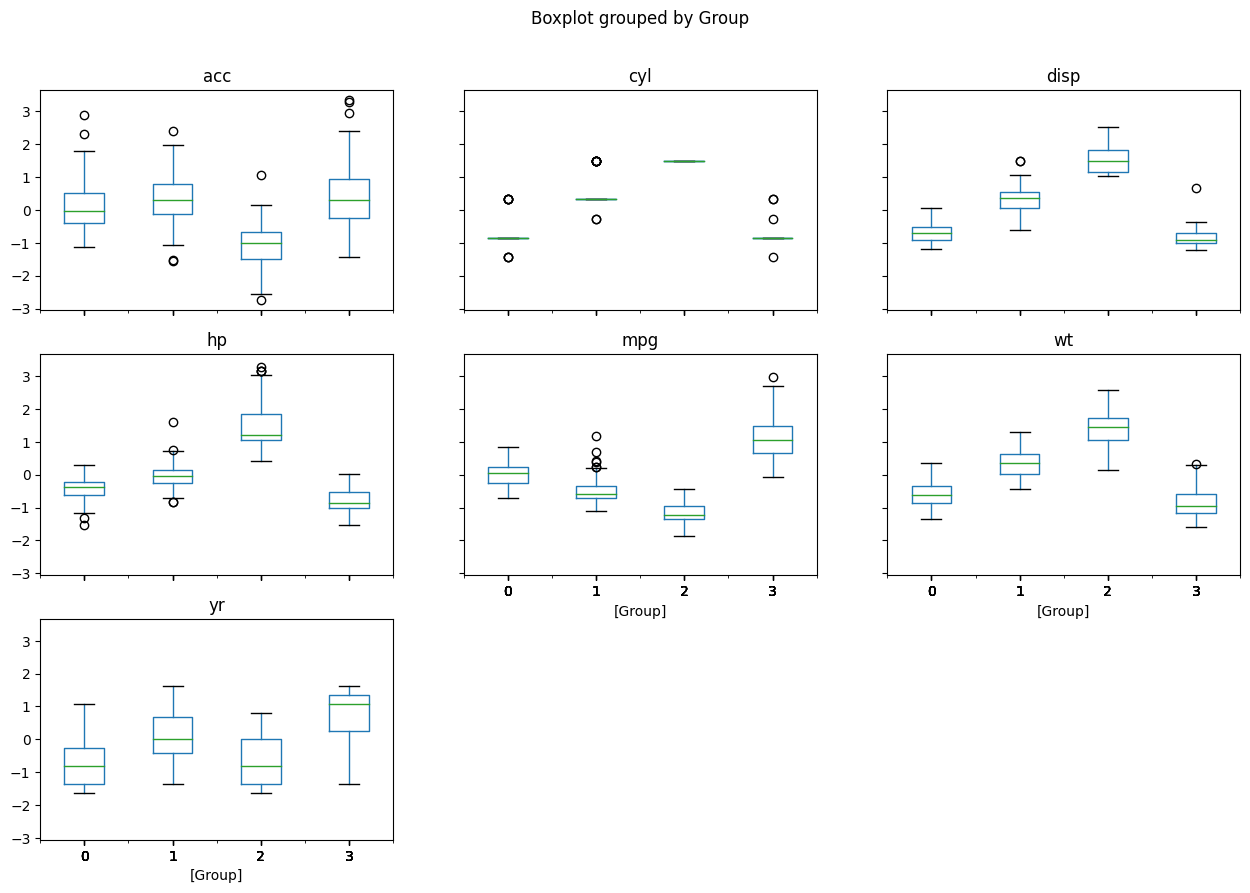

In [49]:
data_z.boxplot(by='Group',layout=(3,3),figsize=(15,10),grid=False)